<a href="https://colab.research.google.com/github/ArtyomShabunin/PINNModels/blob/main/experiment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlflow==2.22.1 dagshub --quiet
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
import mlflow
import dagshub
import pandas as pd
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

import matplotlib.pyplot as plt

In [4]:
dagshub.init("gas-prop-net", "pranamodeling", mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=c16533be-4f50-4f23-b0e7-ea1adddf0ed4&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=1eac76adc1b35607dff163891e89085d38b14c676d601911599b6a70c78e2f7e




Accessing as pranamodeling

Initialized MLflow to track repo "pranamodeling/gas-prop-net"

Repository pranamodeling/gas-prop-net initialized!

### Модель для расчета свойств смесей газов

In [5]:
class GasMixturePropertiesNN(nn.Module):
    def __init__(self, logged_model_uri: str, logged_info_uri: str, freeze: bool = True):
        super().__init__()
        # Загрузка модели и информации о нормализации
        self.raw_model = mlflow.pyfunc.load_model(logged_model_uri).get_raw_model()

        # Заморозка весов
        if freeze:
            for param in self.raw_model.parameters():
                param.requires_grad = False

        with open(mlflow.artifacts.download_artifacts(logged_info_uri)) as f:
            self.model_info = json.load(f)

        # Преобразуем mean и std в тензоры
        self.register_buffer('input_mean', torch.tensor(self.model_info['scaler_input']['mean_'], dtype=torch.float32))
        self.register_buffer('input_std', torch.tensor(self.model_info['scaler_input']['std_'], dtype=torch.float32))
        self.register_buffer('output_mean', torch.tensor(self.model_info['scaler_output']['mean_'], dtype=torch.float32))
        self.register_buffer('output_std', torch.tensor(self.model_info['scaler_output']['std_'], dtype=torch.float32))

    def forward(self, x1: torch.Tensor, x2: torch.Tensor, x3: torch.Tensor) -> torch.Tensor:
        """
        Parameters:
            inputs: Tensor размера (batch_size, n_features) — давление, температура/энтальпия, состав смеси и т.д.
        Returns:
            Tensor размера (batch_size, n_outputs) — физические свойства: T/h, rho, s, mu, lambda, cp
        """

        inputs = torch.cat([x1, x2, x3], axis=1)

        # Нормализация
        x_norm = (inputs - self.input_mean) / self.input_std

        # Предсказание
        y_norm = self.raw_model(x_norm)

        # Обратная нормализация
        y = y_norm * self.output_std + self.output_mean

        return {key:y[:,i:i+1] for i, key in enumerate(self.model_info['output'])}

In [6]:
# Инициализация моделей
gas_pHX = GasMixturePropertiesNN(
    logged_model_uri='runs:/7febe97b33db4e978445b2290c9453d1/mdllol',
    logged_info_uri='mlflow-artifacts:/e7cc815685774faa9f6b047a083f2220/7febe97b33db4e978445b2290c9453d1/artifacts/info.json'
)

gas_pTX = GasMixturePropertiesNN(
    logged_model_uri='runs:/71abefa7c4d5421abbb48f9dd3b7f1b8/mdllol',
    logged_info_uri='mlflow-artifacts:/814e64636dca42cfbac0984ece9bc5fd/71abefa7c4d5421abbb48f9dd3b7f1b8/artifacts/info.json'
)

gas_pSX = GasMixturePropertiesNN(
    logged_model_uri='runs:/6511acddd9874890ba90d6c889756c81/mdllol',
    logged_info_uri='mlflow-artifacts:/25c2c06c1c7f43d3bb10a131022afe84/6511acddd9874890ba90d6c889756c81/artifacts/info.json'
)

2025/06/30 07:04:00 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - accelerate (current: 1.8.1, required: accelerate==1.7.0)
 - boto3 (current: 1.38.46, required: boto3==1.38.41)
 - google-cloud-aiplatform (current: 1.99.0, required: google-cloud-aiplatform==1.97.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


2025/06/30 07:04:15 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - accelerate (current: 1.8.1, required: accelerate==1.7.0)
 - boto3 (current: 1.38.46, required: boto3==1.38.43)
 - google-cloud-aiplatform (current: 1.99.0, required: google-cloud-aiplatform==1.97.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


2025/06/30 07:04:26 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - accelerate (current: 1.8.1, required: accelerate==1.7.0)
 - boto3 (current: 1.38.46, required: boto3==1.38.43)
 - google-cloud-aiplatform (current: 1.99.0, required: google-cloud-aiplatform==1.97.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [7]:
# Тестовый пример
p = torch.tensor([[1e5]])  # Па
T = torch.tensor([[500+273.15]])  # C
X = torch.tensor([[0.23, 0.02, 0.01, 0.04, 0.7]])  # молярные доли

# Вызов модели
output_1 = gas_pTX(p, T, X)

output_1

{'h': tensor([[-106030.5000]]),
 'rho': tensor([[0.2742]]),
 's': tensor([[7638.0269]]),
 'mu': tensor([[3.6202e-05]]),
 'lamb': tensor([[0.0558]]),
 'cp': tensor([[1091.2029]])}

In [8]:
# Вызов модели
output_2 = gas_pHX(p, output_1['h'], X)

print(output_2['T']-273.15)

# output_2

tensor([[515.7235]])


In [9]:
# Вызов модели
output_3 = gas_pSX(p, output_1['s'], X)

output_3['T']-273.15

tensor([[458.6737]])

In [10]:
output_1['rho'], output_2['rho'], output_3['rho']

(tensor([[0.2742]]), tensor([[0.1520]]), tensor([[0.5232]]))

In [11]:
output_1['cp'], output_2['cp'], output_3['cp']

(tensor([[1091.2029]]), tensor([[1094.2025]]), tensor([[1089.2502]]))

In [12]:
# Расчет производных

# Сделаем h дифференцируемым
p = torch.tensor([[1e5]], dtype=torch.float32, requires_grad=True)
h = torch.tensor([[-99757.]], dtype=torch.float32, requires_grad=True)
X = torch.tensor([[0.23, 0.02, 0.01, 0.04, 0.7]], dtype=torch.float32)  # X можно оставить без градиента

# Вызов surrogate-модели
out = gas_pHX(p, h, X)  # dict с ключом 'rho'
rho = out['rho']  # (batch, 1)

# Вычисляем drho/dh
drho_dh = torch.autograd.grad(
    outputs=rho,
    inputs=h,
    grad_outputs=torch.ones_like(rho),
    create_graph=True
)[0]  # (batch, 1)

In [13]:
class PressureTemperatureBC(nn.Module):
    def __init__(self, gas_pTX: GasMixturePropertiesNN):
        super().__init__()
        self.gas_pTX = gas_pTX

    def forward(self, p: torch.Tensor, T: torch.Tensor, X: torch.Tensor) -> torch.Tensor:

        return {
            'p': p,
            'h': self.gas_pTX(p,T, X)['h'],
            'X': X
        }


## Модель компрессора

### CompressorMapInterp — таблично заданная карта по β и скорости вращения

### Класс `Compressor`

In [14]:
class CompressorMapNet_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, 2)  # pi_c, m_dot_rel, eta
        )

    def forward(self, pi, speed_rel):
        x = torch.stack([pi, speed_rel], dim=-1)
        out = self.net(x)
        phic = 1e-4 + F.softplus(out[..., 0])
        eta = 0.6 + 0.4 * torch.sigmoid(out[..., 1])
        return phic, eta

In [15]:
class ParametricCompressorMap(nn.Module):
    def __init__(self):
        super().__init__()

        # Расход (phic)
        self.A_phic = nn.Parameter(torch.tensor(0.5))  # масштаб
        self.B_phic = nn.Parameter(torch.tensor(1.0))  # скорость экспоненциального спада по pi
        self.C_phic = nn.Parameter(torch.tensor(0.1))  # нижняя граница
        self.D_phic = nn.Parameter(torch.tensor(0.3))  # усиление зависимости от speed_rel
        self.speed_ref = nn.Parameter(torch.tensor(1.0), requires_grad=False)  # точка отсчета

        # КПД (eta) — как раньше, параболоид
        self.eta_max = nn.Parameter(torch.tensor(0.85))
        self.eta_pi_opt = nn.Parameter(torch.tensor(2.5))
        self.eta_speed_opt = nn.Parameter(torch.tensor(1.0))
        self.eta_width_pi = nn.Parameter(torch.tensor(1.0))
        self.eta_width_speed = nn.Parameter(torch.tensor(0.5))

    def forward(self, pi, speed_rel):
        # Обеспечим положительность параметров
        A = F.softplus(self.A_phic)
        B = F.softplus(self.B_phic)
        C = F.softplus(self.C_phic)
        D = F.softplus(self.D_phic)

        # Расход: убывает по pi, возрастает по speed_rel
        decay = A * torch.exp(-B * pi)  # убывание по pi
        growth = 1.0 + D * (speed_rel - self.speed_ref)  # возрастающая зависимость от speed
        phic = decay * growth + C
        phic = F.softplus(phic) + 1e-4  # гарантированно положительный

        # КПД: параболоид
        eta = self.eta_max \
            - ((pi - self.eta_pi_opt) / self.eta_width_pi) ** 2 \
            - ((speed_rel - self.eta_speed_opt) / self.eta_width_speed) ** 2
        # eta = torch.clamp(eta, 0.6, 0.95)
        eta = 0.6 + 0.4 * torch.sigmoid(eta)

        return phic, eta

In [16]:
class Compressor_2(nn.Module):
    def __init__(self, gas_pHX, gas_pSX, map, N_T_design = 3000, pi_design = 10, phic_design = 70):
        super().__init__()
        self.map = map
        self.N_T_design = N_T_design # приведенная скорость вращения, об/мин
        self.pi_design = pi_design
        self.phic_design = phic_design

        self.gas_pHX = gas_pHX
        self.gas_pSX = gas_pSX

        self.keys = [
            'w', 'h_out', 'torque', 'pi_c', 'eta', 'phic', 'dphic_dpi', 'dphic_dspeed']

    def forward(self, p_in, h_in, X_in, p_out, omega):

        # Термодинамические параметры газа перед компрессором
        state_in = self.gas_pHX(p_in, h_in, X_in)
        T_in = state_in['T']

        # Относительная приведенная скорость вращения
        N_T = omega/torch.sqrt(T_in/290)/self.N_T_design
        N_T.requires_grad_(True)

        # Целевая степень повышения давления
        # pi_c = (p_out / p_in).clamp(min=1.01)
        pi_c = p_out / p_in
        pi_c_n = (pi_c - 1.0) / (self.pi_design - 1.0)
        pi_c_n.requires_grad_(True)

        # Использование характеристики компрессора
        phic_n, eta = self.map(pi_c_n, N_T)
        phic = phic_n*self.phic_design

        # Учет КПД
        s_in = state_in['s']
        state_iso = gas_pSX(p_out, s_in, X_in)
        h_out_iso = state_iso['h']
        delta_h_iso = h_out_iso - h_in
        delta_h = delta_h_iso / eta
        h_out = h_in + delta_h

        # Расход воздуха
        w = phic*p_in/1.013e5/torch.sqrt(T_in/290)

        torque = (w * delta_h) / (omega * 2 * torch.pi / 60 + 1e-6)


        dphic_dpi = torch.autograd.grad(
            outputs=phic_n,
            inputs=pi_c_n,
            grad_outputs=torch.ones_like(phic_n),
            create_graph=True,
            retain_graph=True
        )[0]

        dphic_dspeed = torch.autograd.grad(
            outputs=phic_n,
            inputs=N_T,
            grad_outputs=torch.ones_like(phic_n),
            create_graph=True,
            retain_graph=True
        )[0]

        return {k: v for k, v in zip(self.keys, [w, h_out, torque, pi_c, eta, phic, dphic_dpi, dphic_dspeed ])}

## Модель газовой турбины

In [17]:
class TurbineMapNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.SiLU(),
            nn.Linear(16, 16),
            nn.SiLU(),
            nn.Linear(16, 1)  # eta
        )

    def forward(self, pi, speed_rel):
        x = torch.stack([pi, speed_rel], dim=-1)
        out = self.net(x)
        eta = 0.6 + 0.4 * torch.sigmoid(out[..., 0])
        return eta

In [18]:
class ParametricTurbineMap(nn.Module):
    def __init__(self):
        super().__init__()
        # Обучаемые параметры: максимум КПД, координаты вершины, ширина по pi и speed_rel
        self.eta_max = nn.Parameter(torch.tensor(0.85))  # максимальный КПД
        self.pi_opt = nn.Parameter(torch.tensor(2.5))     # оптимальная степень давления
        self.speed_opt = nn.Parameter(torch.tensor(1.0))  # оптимальная относительная скорость
        self.width_pi = nn.Parameter(torch.tensor(1.0))   # ширина по pi
        self.width_speed = nn.Parameter(torch.tensor(0.5))  # ширина по speed_rel

    def forward(self, pi, speed_rel):
        # Параболическая форма: η = η_max - A*(pi - pi_opt)^2 - B*(speed_rel - speed_opt)^2
        eta = self.eta_max \
            - ((pi - self.pi_opt) / self.width_pi) ** 2 \
            - ((speed_rel - self.speed_opt) / self.width_speed) ** 2

        # Ограничим η снизу и сверху, чтобы не выходил за физические границы
        # eta = torch.clamp(eta, 0.6, 0.95)
        eta = 0.6 + 0.4 * torch.sigmoid(eta)
        return eta

In [19]:
class GasTurbine(nn.Module):
    def __init__(self,
                 gas_pHX, gas_pSX, map, K,
                 K_design = 10, N_T_design = 3000, pr_design = 10):
        super().__init__()
        self.map = map
        self.N_T_design = N_T_design # приведенная скорость вращения, об/мин
        self.pr_design = pr_design

        self.K = K # Stodola's constant

        self.gas_pHX = gas_pHX
        self.gas_pSX = gas_pSX

        self.keys = ['w', 'h_out', 'torque', 'pr', 'eta', 'phic', 'T_in']

    def forward(self, p_in, h_in, X_in, p_out, omega, K_correct):

        omega_safe = omega + 1e-3

        # Термодинамические параметры газа перед компрессором
        state_in = self.gas_pHX(p_in, h_in, X_in)
        T_in = state_in['T']

        # Относительная приведенная скорость вращения
        N_T = omega_safe/torch.sqrt(T_in/290)/self.N_T_design

        # Степень расширения
        # PR = p_in/p_out
        PR = torch.clamp(p_in / p_out, min=1.01)
        PR_n = (PR - 1.0) / (self.pr_design - 1.0)

        phic = K_correct * self.K * torch.sqrt(1 - (1 / PR) ** 2)
        w = phic * p_in / 1.013e5 / torch.sqrt(T_in/290)

        # КПД
        eta = self.map(PR_n, N_T)

        # Учет КПД
        s_in = state_in['s']
        state_iso = self.gas_pSX(p_out, s_in, X_in)
        h_out_iso = state_iso['h']
        delta_h = (h_in - h_out_iso) * eta
        h_out = h_in - delta_h

        torque = (w * delta_h) / (omega_safe * 2 * torch.pi / 60 + 1e-6)

        return {k: v for k, v in zip(self.keys, [w, h_out, torque, PR, eta, phic, T_in])}


## Модель Камеры сгорания

In [20]:
class CombustionChamber(nn.Module):
    def __init__(self, gas_pHX, HH_fuel, volume=1.0, dt=0.01, h_ref=-656965.6250):
        super().__init__()
        self.volume = volume
        self.HH_fuel = HH_fuel

        self.dt = dt
        self.gas_pHX = gas_pHX
        self.h_ref = h_ref

        # Молярные массы, кг/моль
        self.MM = {
            'CH4': 0.01604246,
            'O2':  0.0319988,
            'H2O': 0.01801528,
            'CO2': 0.0440095
        }

        # Сопоставление индексов компонентов в воздухе
        self.IDX = {
            'O2': 0,
            'Ar': 1,
            'H2O': 2,
            'CO2': 3,
            'N2': 4
        }

        # Сопоставление индексов компонентов в топливе
        self.FUEL_IDX = {
            'N2': 0,
            'CO2': 1,
            'CH4': 2
        }

        self.keys = ['h_new', 'p_new', 'X_new', 'de', 'dp', 'dm', 'dM', 'lambda_']

    def forward(self, m_in, h_in, X_in,
                      m_out, p_curr, h_curr, X_curr,
                      m_fuel, h_fuel, X_fuel):

        state = self.gas_pHX(p_curr, h_curr, X_curr)
        rho = state['rho']  # плотность (кг/м³)

        # drho_dh = torch.autograd.grad(
        #     outputs=rho,
        #     inputs=h_curr,
        #     grad_outputs=torch.ones_like(rho),
        #     create_graph=True,
        #     retain_graph=True
        # )[0]

        drho_dp = torch.autograd.grad(
            outputs=rho,
            inputs=p_curr,
            grad_outputs=torch.ones_like(rho),
            create_graph=True,
            retain_graph=True
        )[0]

        # Относительные энтальпии
        h_in_rel = h_in - self.h_ref
        h_curr_rel = h_curr - self.h_ref
        h_fuel_rel = h_fuel - self.h_ref
        HH_fuel_rel = self.HH_fuel - self.h_ref

        # Масса и энергия
        m_curr = rho * self.volume
        e_curr = m_curr * h_curr_rel

        # Массы компонентов воздуха (5 компонентов)
        M_air = m_in * X_in  # (batch, 5)

        # Преобразуем топливо в 5-компонентный вектор
        M_fuel = torch.zeros_like(M_air)  # (batch, 5)
        M_fuel[:, self.IDX['N2']]  = m_fuel * X_fuel[:, self.FUEL_IDX['N2']]
        M_fuel[:, self.IDX['CO2']] = m_fuel * X_fuel[:, self.FUEL_IDX['CO2']]
        m_CH4 = m_fuel * X_fuel[:, self.FUEL_IDX['CH4']].unsqueeze(1)  # (batch, 1)

        # Молярный расход CH4 (кмоль/с)
        n_CH4 = m_CH4 / self.MM['CH4']

        # учет ограниченного кислорода
        m_O2_avail = M_air[:, self.IDX['O2']].unsqueeze(1)
        m_O2_needed = 2 * n_CH4 * self.MM['O2']
        lambda_ = m_O2_avail / (m_O2_needed + 1e-8)
        combustion_ratio = torch.clamp(lambda_, max=1.0, min=0.0)
        n_CH4_reacted = n_CH4 * combustion_ratio
        n_CH4_unburned = n_CH4 * (1.0 - combustion_ratio)
        m_CH4_unburned = n_CH4_unburned * self.MM['CH4']

        # Массы продуктов реакции
        m_O2_react = 2 * n_CH4_reacted * self.MM['O2']
        m_H2O_prod = 2 * n_CH4_reacted * self.MM['H2O']
        m_CO2_prod = 1 * n_CH4_reacted * self.MM['CO2']

        # Массы компонентов на выходе
        M_out = m_out * X_curr        # (batch, 5)
        M_curr = m_curr * X_curr      # (batch, 5)

        # Изменение масс компонентов
        dM = M_air + M_fuel - M_out
        dM[:, self.IDX['O2']]  -= m_O2_react.squeeze(1)
        dM[:, self.IDX['H2O']] += m_H2O_prod.squeeze(1)
        dM[:, self.IDX['CO2']] += m_CO2_prod.squeeze(1)

        # Новые массы и состав
        M_new = torch.clamp(M_curr + self.dt*dM, min=1e-8)
        X_new = M_new / M_new.sum(dim=1, keepdim=True)



        dm = self.dt * (m_in - m_out + m_fuel)
        m_new = torch.clamp(m_curr + dm, min=1e-6)
        d_rho = dm / self.volume

        de = self.dt * (
            m_in * h_in_rel
            - m_out * h_curr_rel
            + m_fuel * combustion_ratio * (h_fuel_rel + HH_fuel_rel)
        )
        e_new = e_curr + de
        h_new_rel = e_new / m_new
        h_new = h_new_rel + self.h_ref
        dh = h_new - h_curr

        # dp = self.dt * (d_rho - drho_dh * dh / self.dt) / drho_dp
        dp = self.dt * d_rho / drho_dp
        p_new = p_curr + dp

        return {k: v for k, v in zip(self.keys, [h_new, p_new, X_new, de, dp, dm, dM, lambda_])}

## Тестирование

### Тестирование простой модели ГТУ

Создадим данные для обучения математической модели

In [21]:
# Примем расход газов через ГТ
G_gt = torch.tensor([[23]]) # кг/с
p_gt_in = torch.tensor([[9e5]]) # Па
T_gt_in = torch.tensor([[1148]]) # K
X_gt_in = torch.tensor([[0.23, 0.02, 0.01, 0.04, 0.7]])
p_gt_out = torch.tensor([[1e5]])

G_c = torch.tensor([[23]])
p_c_in = torch.tensor([[1e5]])
T_c_in = torch.tensor([[15 + 273.15]])
X_c_in = torch.tensor([[0.23, 0.02, 0.01, 0.04, 0.7]])
p_c_out = torch.tensor([[9e5]])

eta_c = 0.91 # КПД компрессора
eta_gt = 0.94 # КПД турбины

In [22]:
state_gt_in = gas_pTX(p_gt_in, T_gt_in, X_gt_in)
state_gt_iso = gas_pSX(p_gt_out, state_gt_in['s'], X_gt_in)
h_gt_out = state_gt_in['h'] - eta_gt * (state_gt_in['h'] - state_gt_iso['h'])
state_gt_out = gas_pHX(p_gt_out, h_gt_out, X_gt_in)
T_gt_out = state_gt_out['T']
N_gt = G_gt * (state_gt_in['h'] - h_gt_out) # Вт

In [23]:
state_c_in = gas_pTX(p_c_in, T_c_in, X_c_in)
state_c_iso = gas_pSX(p_c_out, state_c_in['s'], X_c_in)
h_c_out = state_c_in['h'] + eta_c * (state_c_iso['h'] - state_c_in['h'])
state_c_out = gas_pHX(p_c_out, h_c_out, X_c_in)
T_c_out = state_c_out['T']
N_c = G_c * (h_c_out - state_c_in['h'])

In [24]:
print((N_gt - N_c) * 1e-6)
print(T_c_out - 273.15)
print(T_gt_out - 273.15)

tensor([[7.8473]])
tensor([[197.8162]])
tensor([[441.9054]])


In [25]:
class GTUModel(nn.Module):
    def __init__(self, gas_pHX, gas_pTX, HH_fuel=33500.0e3, dt=0.001):
        super().__init__()

        self.gas_pTX = gas_pTX
        self.gas_pHX = gas_pHX
        self.gas_pSX = gas_pSX

        # self.cmap = CompressorMapNet_2()
        self.cmap = ParametricCompressorMap()
        # self.eta_f = TurbineMapNet()
        self.eta_f = ParametricTurbineMap()

        self.K_correct = nn.Parameter(torch.tensor(0.1, dtype=torch.float32))

        self.m_fuel_n = nn.Parameter(torch.tensor(0.5, dtype=torch.float32))
        # self.m_fuel_min = torch.tensor(1, dtype=torch.float32)
        self.m_fuel_max = torch.tensor(100, dtype=torch.float32)

        # Компоненты
        self.compressor = Compressor_2(self.gas_pHX, self.gas_pSX, self.cmap, N_T_design = 3000)
        self.turbine = GasTurbine(
            self.gas_pHX, self.gas_pSX, self.eta_f,
            K=100, N_T_design=3000)
        self.comb = CombustionChamber(self.gas_pHX, HH_fuel=HH_fuel, dt=dt)

        self.keys = ['power', 'pc_out', 'tc_out', 'tt_out', 'de', 'dp','dm', 'dM']

    def forward(self, p_in, T_in, X_in, p_out, omega, p_comb_start, T_comb_start, X_comb_start):

        m_fuel_n = 1e-4 + F.softplus(self.m_fuel_n)
        m_fuel = m_fuel_n * self.m_fuel_max

        state_in = self.gas_pTX(p_in, T_in, X_in)
        compressor_out = self.compressor(
            p_in, state_in['h'], X_in, p_comb_start, omega)

        h_comb = self.gas_pTX(p_comb_start, T_comb_start, X_comb_start)['h']
        turbine_out = self.turbine(p_comb_start, h_comb, X_comb_start, p_out, omega, self.K_correct)

        h_fuel = torch.tensor([[-99757.]])
        X_fuel = torch.tensor([[0.02,0.012,0.968]])
        comb_out = self.comb(
            compressor_out['w'], compressor_out['h_out'], X_in,
            turbine_out['w'],
            p_comb_start, h_comb, X_comb_start,
            m_fuel, h_fuel, X_fuel
            )

        tcomb_out = self.gas_pHX(comb_out['p_new'], comb_out['h_new'], comb_out['X_new'])['T']

        power = (turbine_out['torque'] - compressor_out['torque']) * (omega * 2 * torch.pi / 60 + 1e-6)

        # pc_out = comb_out['p_new']
        pc_out = p_comb_start
        tc_out = self.gas_pHX(p_comb_start, compressor_out['h_out'], X_in)['T']

        tt_out = self.gas_pHX(p_out, turbine_out['h_out'], X_comb_start)['T']

        de = comb_out['de']
        dp = comb_out['dp']
        dm = comb_out['dm']
        dM = comb_out['dM']

        result = {k: v for k, v in zip(self.keys, [power, pc_out, tc_out, tt_out, de, dp, dm, dM])}
        result['compressor_out'] = compressor_out
        result['comb_out'] = comb_out
        result['turbine_out'] = turbine_out
        result['m_fuel'] = m_fuel
        result['tcomb_out'] = tcomb_out
        result['p_comb_start'] = p_comb_start
        result['T_comb_start'] = T_comb_start
        result['X_comb_start'] = X_comb_start
        result['K_correct'] = self.K_correct

        return result

In [26]:
class TrainableStartConditions(nn.Module):
    def __init__(self, gas_pHX, gas_pTX, dt=0.001):
        super().__init__()

        # Вложенная модель ГТУ
        self.gtu = GTUModel(gas_pHX, gas_pTX, 33500.0e3, dt)

        # Обучаемые параметры камеры сгорания
        self.p_comb_start_n = nn.Parameter(torch.tensor([[0.5]], dtype=torch.float32))          # Па
        self.p_comb_start_min =  torch.tensor(1e5)
        self.p_comb_start_max =  torch.tensor(14e5)

        self.T_comb_start_n = nn.Parameter(torch.tensor([[0.5]], dtype=torch.float32))            # K
        self.T_comb_start_max = torch.tensor([[1300+273.15]], dtype=torch.float32)
        self.T_comb_start_min = torch.tensor([[700+273.15]], dtype=torch.float32)

        self.X_comb_start = nn.Parameter(torch.tensor([[0.23, 0.02, 0.01, 0.04, 0.7]], dtype=torch.float32)) # массовые доли компонентов

    def forward(self, p_in, T_in, X_in, p_out, omega):
        p_comb_start = self.p_comb_start_n * (self.p_comb_start_max - self.p_comb_start_min) + self.p_comb_start_min
        T_comb_start = self.T_comb_start_n * (self.T_comb_start_max - self.T_comb_start_min) + self.T_comb_start_min

        # Обеспечим положительность и нормировку состава
        X_positive = F.softplus(self.X_comb_start) + 1e-6  # чтобы точно избежать деления на 0
        X_comb_start = X_positive / X_positive.sum(dim=1, keepdim=True)

        return self.gtu(
            p_in=p_in,
            T_in=T_in,
            X_in=X_in,
            p_out=p_out,
            omega=omega,
            p_comb_start=p_comb_start,
            T_comb_start=T_comb_start,
            X_comb_start=self.X_comb_start
        )


In [27]:
# gt_model = GTUModel(gas_pHX, gas_pTX)

In [28]:
# gt_model(
#     p_in=torch.tensor([[1e5]]),
#     T_in=torch.tensor([[15+273.15]]),
#     X_in=torch.tensor([[0.23, 0.02, 0.01, 0.04, 0.7]]),
#     p_out=torch.tensor([[1e5]]),
#     m_fuel=torch.tensor([[1]]),
#     omega=torch.tensor([[3e3]]),
#     p_comb_start=torch.tensor([[5e5]]),
#     T_comb_start=torch.tensor([[900+273.15]]),
#     X_comb_start=torch.tensor([[0.23, 0.02, 0.01, 0.04, 0.7]])
# )

In [29]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# # === 1. Подготовка входов ===
# p_in = torch.tensor([[1e5]])
# T_in = torch.tensor([[15.0 + 273.15]])
# X_in = torch.tensor([[0.23, 0.02, 0.01, 0.04, 0.7]])
# p_out = torch.tensor([[1e5]])
# omega = torch.tensor([[3000.0]])

# # === 2. Целевые значения ===
# target = {
#     'power': torch.tensor([[6e6]]),
#     'pc_out': torch.tensor([[9e5]]),
#     'tc_out': torch.tensor([[135.0 + 273.15]]),
#     'tt_out': torch.tensor([[532.0 + 273.15]]),
#     'de': torch.tensor([[0.0]]),
#     'dp': torch.tensor([[0.0]]),
#     'dm': torch.tensor([[0.0]]),
#     'dM': torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0]]),
# }

# # === 3. Инициализация модели ===
# dt = 0.01
# model = TrainableStartConditions(gas_pHX, gas_pTX, dt=dt)
# model.train()

# # === 4. Критерий ошибки и GradNorm ===
# loss_fn = nn.MSELoss()
# # task_names = list(target.keys())

# # === GradNorm ===
# class GradNormLoss(nn.Module):
#     def __init__(self, model, task_names, alpha=1.5):
#         super().__init__()
#         self.model = model
#         self.task_names = task_names
#         self.alpha = alpha
#         self.num_tasks = len(task_names)
#         self.task_weights = nn.Parameter(torch.ones(self.num_tasks))
#         self.register_buffer('initial_losses', torch.zeros(self.num_tasks))
#         self.initialized = False

#     def forward(self, losses, shared_parameters):
#         task_losses = torch.stack([losses[t] for t in self.task_names])
#         weights = torch.relu(self.task_weights)

#         if not self.initialized:
#             self.initial_losses = task_losses.detach()
#             self.initialized = True

#         weighted_loss = torch.sum(weights * task_losses)

#         grads = []
#         for i, t in enumerate(self.task_names):
#             self.model.zero_grad()
#             (weights[i] * losses[t]).backward(retain_graph=True)
#             grad = torch.cat([
#                 p.grad.detach().flatten()
#                 for p in shared_parameters if p.grad is not None
#             ])
#             grads.append(torch.norm(grad, 2))

#         grads = torch.stack(grads)

#         with torch.no_grad():
#             loss_ratios = task_losses.detach() / self.initial_losses
#             avg_ratio = torch.mean(loss_ratios)
#             target_grads = grads.mean() * (loss_ratios / avg_ratio) ** self.alpha

#         gradnorm_loss = nn.functional.l1_loss(grads, target_grads.detach())
#         return weighted_loss + gradnorm_loss, weighted_loss.detach(), weights.detach()

# task_names = ['power', 'pc_out', 'tc_out', 'tt_out',
#                   'de', 'dp', 'dm', 'dM',
#                   'penalty_temp', 'penalty_lambda', 'fuel_penalty']

# gradnorm_loss_fn = GradNormLoss(model, task_names)

# # === 5. Оптимизатор: включает параметры модели и GradNorm ===
# optimizer = optim.Adam(
#     list(model.parameters()) + list(gradnorm_loss_fn.parameters()),
#     lr=1e-3
# )

# # === 6. Цикл обучения ===
# n_epochs = 10000
# losses = []

# for epoch in range(n_epochs):
#     optimizer.zero_grad()

#     # Прогон модели
#     output = model(p_in, T_in, X_in, p_out, omega)

#     # Потери по задачам
#     per_task_losses = {
#         'power': loss_fn(output['power'], target['power']),
#         'pc_out': loss_fn(output['pc_out'], target['pc_out']),
#         'tc_out': loss_fn(output['tc_out'], target['tc_out']),
#         'tt_out': loss_fn(output['tt_out'], target['tt_out']),
#         'de': loss_fn(output['de'], target['de']),
#         'dp': loss_fn(output['dp'], target['dp']),
#         'dm': loss_fn(output['dm'], target['dm']),
#         'dM': loss_fn(output['dM'], target['dM']),
#         'penalty_temp': torch.relu(output['tcomb_out'] - (1500.0 + 273.15)).mean(),
#         'penalty_lambda': torch.relu(1.0 - output['comb_out']['lambda_']).mean(),
#         'fuel_penalty':  output['m_fuel'].mean()
#     }

#     shared_params = list(model.parameters())

#     # GradNorm loss
#     total_loss, weighted_loss_only, current_weights = gradnorm_loss_fn(per_task_losses, shared_params)

#     # Штрафы (не балансируются GradNorm)
#     # penalty_temp = torch.relu(output['tcomb_out'] - (1500.0 + 273.15)).mean()
#     # penalty_lambda = torch.relu(1.0 - output['comb_out']['lambda_']).mean()

#     # total_loss += penalty_temp + penalty_lambda

#     # Обратное распространение + шаг
#     total_loss.backward()
#     optimizer.step()

#     losses.append(total_loss.item())

#     if epoch % 100 == 0 or epoch == n_epochs - 1:
#         print(f"Epoch {epoch}: total_loss = {total_loss.item():.4e}, weighted_loss = {weighted_loss_only.item():.4e}")
#         print(f"Task weights: {current_weights}")


In [30]:
# model(p_in, T_in, X_in, p_out, omega)

In [37]:
# 1. Подготовка входов (один обучающий пример)
p_in = torch.tensor([[1e5]])                     # Па
T_in = torch.tensor([[15.0 + 273.15]])           # К
X_in = torch.tensor([[0.23, 0.02, 0.01, 0.04, 0.7]])  # массовые доли
p_out = torch.tensor([[1e5]])
omega = torch.tensor([[3000.0]])

# 2. Целевые значения
target = {
    'power': torch.tensor([[6e6]]),
    'pc_out': torch.tensor([[9e5]]),
    'tc_out': torch.tensor([[135.0+273.15]]),
    'tt_out': torch.tensor([[532.0+273.15]]),
    'de': torch.tensor([[0.0]]),
    'dp': torch.tensor([[0.0]]),
    'dm': torch.tensor([[0.0]]),
    'dM': torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0]]),
}

# 3. Инициализация модели
dt = 1
model = TrainableStartConditions(gas_pHX, gas_pTX, dt=dt)
model.train();

# 4. Оптимизатор
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

# 5. Критерий ошибки
loss_fn = nn.MSELoss()



In [38]:
# 6. Цикл обучения
n_epochs = 10000

In [39]:
start_params = [
    model.p_comb_start_n,
    model.T_comb_start_n,
    model.X_comb_start,
]
# start_params_ids = set(id(p) for p in start_params)

# main_params = [p for p in model.parameters() if id(p) not in start_params_ids]
main_params = list(model.gtu.cmap.parameters()) + \
              list(model.gtu.eta_f.parameters()) + \
              [model.gtu.K_correct, model.gtu.m_fuel_n, model.p_comb_start_n, model.T_comb_start_n,]

In [40]:
optimizer_start = optim.Adam(start_params, lr=1e-3)
optimizer_main = optim.Adam(main_params, lr=1e-3)

In [ ]:
main_total_losses = []
start_losses = []

# losses = []

torch.autograd.set_detect_anomaly(True)

for epoch in range(n_epochs):
    optimizer_main.zero_grad()
    optimizer_start.zero_grad()

    # Прогон модели
    output = model(p_in, T_in, X_in, p_out, omega)

    main_loss = (
        1e-6 * loss_fn(output['power'], target['power']) +
        1e-5 * loss_fn(output['pc_out'], target['pc_out']) +
        1e-3 * loss_fn(output['tc_out'], target['tc_out']) +
        1e-3 * loss_fn(output['tt_out'], target['tt_out'])
    )


    penalty = torch.relu(output['tcomb_out'] - (1500.0+273.15)).mean() * 1e3
    penalty_lambda = torch.relu(1.0 - output['comb_out']['lambda_']).mean() * 1e3
    fuel_penalty = output['m_fuel'].mean().abs() * 1e3
    penalty_dpi = torch.relu(output['compressor_out']['dphic_dpi'] + 1e-4) * 1e3
    penalty_dspeed = torch.relu(1e-4 - output['compressor_out']['dphic_dspeed']) * 1e3

    # Общие
    penalty_loss = penalty + penalty_lambda + fuel_penalty + penalty_dpi + penalty_dspeed

    # 1. Обратное распространение
    main_total_loss = main_loss + penalty_loss

    # Zero grads
    optimizer_main.zero_grad()


    # # Обратное распространение и шаг оптимизации
    # loss.backward()


    main_total_loss.backward(retain_graph=True)
    optimizer_main.step()


    output = model(p_in, T_in, X_in, p_out, omega)

    start_loss = (
        1e6 / dt * loss_fn(output['de'], target['de']) +
        1e6 / dt * loss_fn(output['dp'], target['dp']) +
        1e6 / dt * loss_fn(output['dM'], target['dM'])
    )

    optimizer_start.zero_grad()



    # optimizer_main.zero_grad()
    # optimizer_start.zero_grad()

    # optimizer.step()

    start_loss.backward()
    optimizer_start.step()


    # # losses.append(loss.item())
    # main_total_losses.append(main_total_loss.item())
    # start_losses.append(start_loss.item())


    if epoch % 100 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch}: main_total_loss = {main_total_loss.item():.4f}")
        print(f"Epoch {epoch}: start_loss = {start_loss.item():.4f}")
        # print("Outputs:", {k: output[k].item() for k in output})
        print("Outputs:", output)

Epoch 0: main_total_loss = 596225984.0000
Epoch 0: start_loss = 36668954432597106098176.0000
Outputs: {'power': tensor([[-18192592.]], grad_fn=<MulBackward0>), 'pc_out': tensor([[751300.]], grad_fn=<AddBackward0>), 'tc_out': tensor([[618.9180]], grad_fn=<SliceBackward0>), 'tt_out': tensor([[1027.3446]], grad_fn=<SliceBackward0>), 'de': tensor([[1.8445e+08]], grad_fn=<MulBackward0>), 'dp': tensor([[51440440.]], grad_fn=<DivBackward0>), 'dm': tensor([[154.0454]], grad_fn=<MulBackward0>), 'dM': tensor([[-8.0853,  1.1338, 12.4597, 17.9623, 41.6301]], grad_fn=<CopySlices>), 'compressor_out': {'w': tensor([[91.8435]], grad_fn=<DivBackward0>), 'h_out': tensor([[-285446.9375]], grad_fn=<AddBackward0>), 'torque': tensor([[92349.5234]], grad_fn=<DivBackward0>), 'pi_c': tensor([[7.5130]], grad_fn=<DivBackward0>), 'eta': tensor([[0.6364]], grad_fn=<AddBackward0>), 'phic': tensor([[97.4130]], grad_fn=<MulBackward0>), 'dphic_dpi': tensor([[-0.3571]], grad_fn=<MulBackward0>), 'dphic_dspeed': tensor([

In [36]:
model(p_in, T_in, X_in, p_out, omega)

{'power': tensor([[5998643.]], grad_fn=<MulBackward0>),
 'pc_out': tensor([[922272.1250]], grad_fn=<AddBackward0>),
 'tc_out': tensor([[633.2552]], grad_fn=<SliceBackward0>),
 'tt_out': tensor([[1036.3572]], grad_fn=<SliceBackward0>),
 'de': tensor([[1050954.7500]], grad_fn=<MulBackward0>),
 'dp': tensor([[4998.9307]], grad_fn=<DivBackward0>),
 'dm': tensor([[1.3549]], grad_fn=<MulBackward0>),
 'dM': tensor([[-1.8606e+01, -4.2627e-03,  1.1042e+01,  1.5076e+01,  5.2229e+00]],
        grad_fn=<CopySlices>),
 'compressor_out': {'w': tensor([[84.3603]], grad_fn=<DivBackward0>),
  'h_out': tensor([[-269939.9375]], grad_fn=<AddBackward0>),
  'torque': tensor([[88989.1016]], grad_fn=<DivBackward0>),
  'pi_c': tensor([[9.2227]], grad_fn=<DivBackward0>),
  'eta': tensor([[0.7146]], grad_fn=<AddBackward0>),
  'phic': tensor([[89.4760]], grad_fn=<MulBackward0>),
  'dphic_dpi': tensor([[-0.2503]], grad_fn=<MulBackward0>),
  'dphic_dspeed': tensor([[0.1710]], grad_fn=<MulBackward0>)},
 'comb_out': 

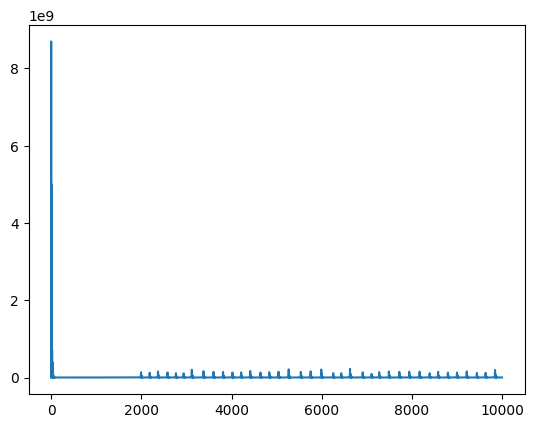

In [ ]:
plt.plot(losses)

In [197]:
for name, param in model.named_parameters():
    print(name, param.shape)
    print(param.data)

p_comb_start_n torch.Size([1, 1])
tensor([[0.5579]])
T_comb_start_n torch.Size([1, 1])
tensor([[0.5283]])
X_comb_start torch.Size([1, 5])
tensor([[ 0.2784,  0.0722, -0.0141, -0.0058,  0.7492]])
gtu.K_correct torch.Size([])
tensor(0.4997)
gtu.m_fuel_n torch.Size([])
tensor(-2.4571)
gtu.gas_pTX.raw_model.net.0.weight torch.Size([1024, 7])
tensor([[ 0.0472,  0.0502, -0.3212,  ..., -0.3645, -0.3440,  0.3590],
        [ 0.3105,  0.0897,  0.3514,  ..., -0.2082,  0.3134, -0.0202],
        [ 0.0861,  0.2161,  0.1948,  ..., -0.1508, -0.3453,  0.0146],
        ...,
        [-0.2959, -0.0075, -0.2784,  ..., -0.1487, -0.2016,  0.1318],
        [-0.1818, -0.2622,  0.1039,  ...,  0.2887,  0.2628,  0.1030],
        [ 0.0999,  0.0961, -0.1642,  ..., -0.3698, -0.2280,  0.1994]])
gtu.gas_pTX.raw_model.net.0.bias torch.Size([1024])
tensor([ 0.3417,  0.3808,  0.2641,  ..., -0.3248,  0.0439,  0.1793])
gtu.gas_pTX.raw_model.net.2.weight torch.Size([1024, 1024])
tensor([[-3.1545e-02,  1.5066e-02, -2.6975e-02

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

p_comb_start: requires_grad=True
T_comb_start: requires_grad=True
X_comb_start: requires_grad=True
gtu.K: requires_grad=True
gtu.HH_fuel: requires_grad=True
gtu.gas_pTX.raw_model.net.0.weight: requires_grad=False
gtu.gas_pTX.raw_model.net.0.bias: requires_grad=False
gtu.gas_pTX.raw_model.net.2.weight: requires_grad=False
gtu.gas_pTX.raw_model.net.2.bias: requires_grad=False
gtu.gas_pTX.raw_model.net.4.weight: requires_grad=False
gtu.gas_pTX.raw_model.net.4.bias: requires_grad=False
gtu.gas_pTX.raw_model.net.6.weight: requires_grad=False
gtu.gas_pTX.raw_model.net.6.bias: requires_grad=False
gtu.gas_pHX.raw_model.net.0.weight: requires_grad=False
gtu.gas_pHX.raw_model.net.0.bias: requires_grad=False
gtu.gas_pHX.raw_model.net.2.weight: requires_grad=False
gtu.gas_pHX.raw_model.net.2.bias: requires_grad=False
gtu.gas_pHX.raw_model.net.4.weight: requires_grad=False
gtu.gas_pHX.raw_model.net.4.bias: requires_grad=False
gtu.gas_pHX.raw_model.net.6.weight: requires_grad=False
gtu.gas_pHX.raw_m